# Similarity Check

Quickly test out different types of similarity metrics!

In [1]:
import TFO_dataset
from math import pi
from sklearn.gaussian_process import *
from inverse_modelling_tfo.data.intensity_interpolation import interpolate_exp_chunk, get_interpolate_fit_params, interpolate_exp
from inverse_modelling_tfo.data import normalize_zero_mean 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [2]:
# Load Data
train_data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/intensity_averaged_sim_data.pkl')
train_data['Intensity'] /= 20   # Normalize by the number of detectors per ring
train_data.head()

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a
0,10,0.032701,2.0,6.0,8.0,0.005,0.05
1,15,0.016661,2.0,6.0,8.0,0.005,0.05
2,19,0.007108,2.0,6.0,8.0,0.005,0.05
3,24,0.002551,2.0,6.0,8.0,0.005,0.05
4,29,0.000802,2.0,6.0,8.0,0.005,0.05


In [3]:
# Interpolate and get fitting parameters
# interpolated_training_data = interpolate_exp(train_data, weights=[1.0, -3])
interpolated_training_data = get_interpolate_fit_params(train_data, weights=[1, -2])
feature_names = [f'f{i + 1}' for i in range(7)]
interpolated_training_data.head()

,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0,alpha1,alpha2,alpha3
0,2.0,6.0,8.0,0.0050,0.05,-39.442281,0.349721,-27.786904,55.867534
1,2.0,6.0,8.0,0.0055,0.05,-40.338040,0.370707,-28.629707,57.413853
2,2.0,6.0,8.0,0.0060,0.05,-41.226881,0.391609,-29.467421,58.949999
3,2.0,6.0,8.0,0.0065,0.05,-42.108920,0.412430,-30.300195,60.476219
4,2.0,6.0,8.0,0.0070,0.05,-42.984230,0.433175,-31.128132,61.992677


In [4]:
# Incorporate both wavelengths by moving to a Wide Format from Long Format
interpolated_training_data = interpolated_training_data.pivot_table(index=['Uterus Thickness', 'Maternal Wall Thickness', 'Maternal Mu_a', 'Fetal Mu_a'], columns='Wave Int', values=['alpha0', 'alpha1', 'alpha2', 'alpha3']).reset_index()
def _renaming_func(x, y):
    if y == '':
        return f'{x}'
    else:
        return f'{x}_{int(y)}'
interpolated_training_data.columns = [_renaming_func(x, y) for x,y in interpolated_training_data.columns]
interpolated_training_data.head()

,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0_1,alpha0_2,alpha1_1,alpha1_2,alpha2_1,alpha2_2,alpha3_1,alpha3_2
0,5.0,2.0,0.005,0.050,-12.592608,3.395675,0.373749,0.413286,-14.666515,-10.940015,23.954485,10.568332
1,5.0,2.0,0.005,0.055,-13.102171,2.622967,0.388989,0.431987,-15.231653,-11.677655,24.949038,11.923494
2,5.0,2.0,0.005,0.060,-13.573916,1.912768,0.402962,0.449012,-15.751852,-12.352166,25.866022,13.164688
3,5.0,2.0,0.005,0.065,-14.013569,1.251053,0.415860,0.464721,-16.233896,-12.977252,26.717161,14.316873
4,5.0,2.0,0.005,0.070,-14.425410,0.628060,0.427827,0.479371,-16.682951,-13.562583,27.511341,15.397590


## Range Check
How does the range of these metrics look like? And can they be matched by our TFO PPG data

In [5]:
feature_names = [f'f{i + 1}' for i in range(7)]
alphas = ['alpha0_1', 'alpha0_2', 'alpha1_1', 'alpha1_2', 'alpha2_1', 'alpha2_2', 'alpha3_1', 'alpha3_2']
interpolated_training_data['f1'] =  interpolated_training_data['alpha0_1'] / interpolated_training_data['alpha0_2']
interpolated_training_data['f2'] =  interpolated_training_data['alpha1_1']
interpolated_training_data['f3'] =  interpolated_training_data['alpha1_2']
interpolated_training_data['f4'] =  interpolated_training_data['alpha2_1']
interpolated_training_data['f5'] =  interpolated_training_data['alpha2_2']
interpolated_training_data['f6'] =  interpolated_training_data['alpha3_1']
interpolated_training_data['f7'] =  interpolated_training_data['alpha3_2']

In [6]:
interpolated_training_data[feature_names].describe()

,f1,f2,f3,f4,f5,f6,f7
count,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000,5700.000000
mean,1.049398,0.017903,-0.036008,-6.990348,-6.161443,13.700853,12.282735
std,81.111484,0.313214,0.567172,11.872523,22.050394,21.846639,40.527367
min,-1463.953823,-0.279149,-0.969527,-38.365712,-73.645903,-7.092476,-47.899452
25%,-0.674764,-0.176774,-0.320702,-13.895279,-0.693436,-0.388036,-7.024968
50%,0.756765,-0.149993,-0.174133,-0.163800,0.556922,1.035428,-0.282519
75%,1.108802,0.141484,-0.128106,0.568120,4.470125,25.751065,1.915740
max,5652.366870,0.832926,1.674688,4.418059,26.968263,71.734372,136.562347


In [7]:
# Sheep Data
sheep_id = 36
data = TFO_dataset.SheepData('iq_demod_optical').get(sheep_id)
print(TFO_dataset.SheepData('iq_demod_optical').get_tuple(sheep_id))
# Pick a point in time
spatial_intensity = data.iloc[70 * 80 ].copy().to_numpy()  # 80Hz sampling freq.
spatial_intensity *=  pi * 4   # from unit area -> pi r^2 area -> match simulation
# spatial_intensity *=  20   # To account for remaining mismatch in power
SDD = [15, 30, 45, 70, 100]     # For our TFO device, in mm


(7, 1, 'sp2022')


In [8]:
def similarity_metric(simulation_alphas, patient_data):
    # Calculate intensity at given SDDs
    a0, a1, a2, a3, b0, b1, b2, b3  = np.array(simulation_alphas)
    m0, m1, m2, m3 = interpolate_exp_chunk(pd.DataFrame({'SDD' : SDD, 'Intensity' : patient_data[:5]}), weights=[1, -1], return_alpha=True)
    n0, n1, n2, n3 = interpolate_exp_chunk(pd.DataFrame({'SDD' : SDD, 'Intensity' : patient_data[5:]}), weights=[1, -1], return_alpha=True)
    
    # simulated_data_wv1 = np.array([np.exp(a0 + a1 * x + a2 * np.sqrt(x) + a3*np.power(x, 1/3)) for x in SDD])
    # simulated_data_wv2 = np.array([np.exp(b0 + b1 * x + b2 * np.sqrt(x) + b3*np.power(x, 1/3)) for x in SDD])
    # simulated_data = np.hstack([simulated_data_wv1, simulated_data_wv2])
    # metric = np.sum(np.exp(np.square(np.log(patient_data) - np.log(simulated_data))))
    metric = np.sqrt((m0/n0 - a0/b0)**2 + (a1 - m1)**2 + (a2 - m2)**2 + (a3 - m3)**2 + + (b1 - n1)**2 + (b2 - n2)**2 + (b3 - n3)**2)
    return metric
    

In [9]:
interpolated_training_data['Metric'] = interpolated_training_data.apply(lambda X: similarity_metric([X['alpha0_1'], X['alpha1_1'], X['alpha2_1'], X['alpha3_1'], X['alpha0_2'], X['alpha1_2'], X['alpha2_2'], X['alpha3_2']], spatial_intensity), axis=1)
interpolated_training_data['Metric'] /= interpolated_training_data['Metric'].sum()    # Normalize to sum of 1
interpolated_training_data = interpolated_training_data.sort_values('Metric', ascending=True)
interpolated_training_data.head(10)

,Uterus Thickness,Maternal Wall Thickness,Maternal Mu_a,Fetal Mu_a,alpha0_1,alpha0_2,alpha1_1,alpha1_2,alpha2_1,alpha2_2,alpha3_1,alpha3_2,f1,f2,f3,f4,f5,f6,f7,Metric
2719,6.0,18.0,0.0055,0.095,0.757306,0.508197,-0.277265,-0.308418,4.372714,4.781362,-7.046827,-7.381815,1.490183,-0.277265,-0.308418,4.372714,4.781362,-7.046827,-7.381815,[0.00013399990600883001]
2729,6.0,18.0,0.0060,0.095,0.754294,0.664769,-0.278707,-0.313154,4.290497,4.842336,-6.929638,-7.533126,1.134671,-0.278707,-0.313154,4.290497,4.842336,-6.929638,-7.533126,[0.0001340293647428739]
2709,6.0,18.0,0.0050,0.095,0.713557,0.351481,-0.274834,-0.303719,4.418059,4.723000,-7.092476,-7.233794,2.030143,-0.274834,-0.303719,4.418059,4.723000,-7.092476,-7.233794,[0.00013404714826985254]
2739,6.0,18.0,0.0065,0.095,0.704366,0.822143,-0.279149,-0.317948,4.170985,4.906620,-6.740291,-7.689112,0.856744,-0.279149,-0.317948,4.170985,4.906620,-6.740291,-7.689112,[0.00013413406171827044]
2718,6.0,18.0,0.0055,0.090,0.682721,0.504566,-0.275457,-0.308336,4.306010,4.778219,-6.922733,-7.375898,1.353086,-0.275457,-0.308336,4.306010,4.778219,-6.922733,-7.375898,[0.00013413801714500998]
2708,6.0,18.0,0.0050,0.090,0.649348,0.348413,-0.273260,-0.303650,4.360396,4.720339,-6.985372,-7.228789,1.863734,-0.273260,-0.303650,4.360396,4.720339,-6.985372,-7.228789,[0.00013416530349346593]
2728,6.0,18.0,0.0060,0.090,0.668915,0.660505,-0.276654,-0.313058,4.214382,4.838650,-6.787864,-7.526182,1.012732,-0.276654,-0.313058,4.214382,4.838650,-6.787864,-7.526182,[0.0001341878748553378]
2717,6.0,18.0,0.0055,0.085,0.603599,0.500861,-0.273534,-0.308253,4.235174,4.775010,-6.791003,-7.369858,1.205122,-0.273534,-0.308253,4.235174,4.775010,-6.791003,-7.369858,[0.00013428472675483237]
2707,6.0,18.0,0.0050,0.085,0.580998,0.345281,-0.271582,-0.303579,4.298955,4.717623,-6.871291,-7.223678,1.682682,-0.271582,-0.303579,4.298955,4.717623,-6.871291,-7.223678,[0.00013429133720204824]
2749,6.0,18.0,0.0070,0.095,0.609226,0.981136,-0.278622,-0.322819,4.015381,4.974811,-6.481216,-7.850965,0.620940,-0.278622,-0.322819,4.015381,4.974811,-6.481216,-7.850965,[0.00013431055324015777]


In [10]:
def plot_top_n_similar_curves(similarity_table : pd.DataFrame, patient_data, n: int = 10):
    plt.figure()
    for i in range(n):
        X = similarity_table.iloc[i, :]
        simulation_alphas = [X['alpha0_1'], X['alpha1_1'], X['alpha2_1'], X['alpha3_1']]
        # Logic
        a0, a1, a2, a3 = simulation_alphas
        simulated_data = np.array([np.exp(a0 + a1 * x + a2 * np.sqrt(x) + a3*np.power(x, 1/3)) for x in SDD])
        patient_data = np.array(patient_data[:5])
        plt.plot(SDD, simulated_data, label=f'Simulation Match Top {i + 1}')
    
    # Plot cleanup
    plt.plot(SDD, patient_data, label='Sheep Data')
    plt.legend()
    plt.yscale('log')
    return plt.gca()
    

<AxesSubplot:>

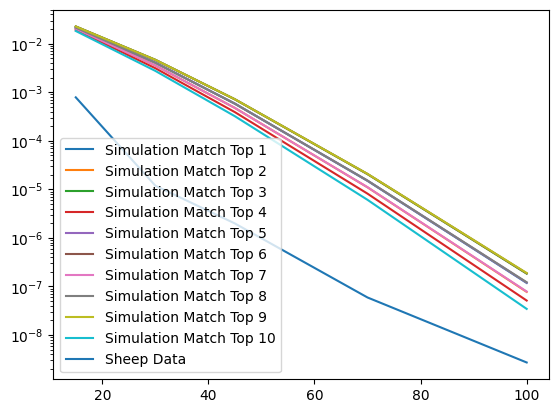

In [11]:
plot_top_n_similar_curves(interpolated_training_data, spatial_intensity)